In [1]:
import numpy as np

import os

from statsmodels.stats.api import DescrStatsW
from scipy.stats import ttest_rel, sem

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def labels_to_counts(labels, time_axis=0):
    onehot = np.zeros((labels.size, n_classes), dtype=int)
    onehot[np.arange(labels.size), labels] = 1
    
    return onehot.cumsum(axis=time_axis)


def log_utility(counts):
    return np.log(counts[:, 1:] + 1).sum(axis=1)


def linear_utility(counts):
    return counts[:, 1:].sum(axis=1)


data = 'morgan'
group_size = 1
num_exps = 120
num_repeats_per_exp = 1

policies = [
    'ens jensen greedy',
    'classical ens',
    'greedy',
    # 'round robin greedy',
]
utility_function = log_utility

n_classes = group_size + 1
init_size = 1
budget = 500

basepath = os.path.join('../../data/results', data)


utilities = np.ones(
    (len(policies), num_exps, num_repeats_per_exp, budget + init_size)
) * -1

for p_ind, policy in enumerate(policies):
    for exp_ind in range(num_exps):
        path = os.path.join(basepath, f'{data}{exp_ind + 1}', str(group_size), policy)
        for i in range(num_repeats_per_exp):
            labels = np.loadtxt(
                os.path.join(path, f'{policy}__labels__{i + 1}.csv'), 
                dtype=int
            ).flatten() - 1

            utilities[p_ind, exp_ind, i, :] = linear_utility(labels_to_counts(labels))
        
assert np.all(utilities != -1)

In [3]:
utilities.shape

(3, 120, 1, 501)

In [4]:
utilities[..., -1].mean(axis=(1, 2))

array([150.43333333, 152.83333333, 149.33333333])

ens jensen greedy: 150.4333
classical ens: 152.8333
greedy: 149.3333


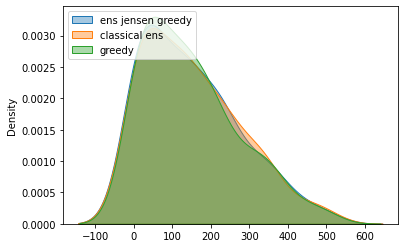

In [5]:
for p_ind, policy in enumerate(policies):
    print(f'{policy}: {utilities[p_ind, ..., -1].mean():.4f}')
    sns.kdeplot(utilities[p_ind, ..., -1].flatten(), alpha=0.4, shade=True, label=policy)
    
plt.legend(loc='upper left');

In [6]:
print(utilities.shape)
utilities

(3, 120, 1, 501)


array([[[[  1.,   1.,   1., ..., 215., 215., 216.]],

        [[  1.,   1.,   1., ..., 241., 241., 241.]],

        [[  1.,   1.,   1., ..., 147., 148., 149.]],

        ...,

        [[  1.,   1.,   2., ..., 211., 212., 212.]],

        [[  1.,   1.,   1., ...,   4.,   4.,   4.]],

        [[  1.,   1.,   2., ..., 258., 258., 258.]]],


       [[[  1.,   1.,   1., ..., 140., 140., 140.]],

        [[  1.,   1.,   1., ..., 247., 247., 247.]],

        [[  1.,   1.,   1., ..., 149., 149., 149.]],

        ...,

        [[  1.,   2.,   3., ..., 223., 223., 223.]],

        [[  1.,   1.,   1., ...,   4.,   4.,   4.]],

        [[  1.,   1.,   2., ..., 256., 257., 257.]]],


       [[[  1.,   2.,   3., ..., 197., 198., 199.]],

        [[  1.,   2.,   3., ..., 292., 292., 292.]],

        [[  1.,   2.,   3., ..., 151., 151., 151.]],

        ...,

        [[  1.,   2.,   3., ..., 148., 148., 148.]],

        [[  1.,   2.,   3., ...,   4.,   4.,   4.]],

        [[  1.,   2.,   3., ..., 193

In [7]:
squeezed_utilities =  utilities.reshape(
    len(policies), 
    num_exps * num_repeats_per_exp, 
    budget + init_size
)

print(squeezed_utilities.shape)
squeezed_utilities

(3, 120, 501)


array([[[  1.,   1.,   1., ..., 215., 215., 216.],
        [  1.,   1.,   1., ..., 241., 241., 241.],
        [  1.,   1.,   1., ..., 147., 148., 149.],
        ...,
        [  1.,   1.,   2., ..., 211., 212., 212.],
        [  1.,   1.,   1., ...,   4.,   4.,   4.],
        [  1.,   1.,   2., ..., 258., 258., 258.]],

       [[  1.,   1.,   1., ..., 140., 140., 140.],
        [  1.,   1.,   1., ..., 247., 247., 247.],
        [  1.,   1.,   1., ..., 149., 149., 149.],
        ...,
        [  1.,   2.,   3., ..., 223., 223., 223.],
        [  1.,   1.,   1., ...,   4.,   4.,   4.],
        [  1.,   1.,   2., ..., 256., 257., 257.]],

       [[  1.,   2.,   3., ..., 197., 198., 199.],
        [  1.,   2.,   3., ..., 292., 292., 292.],
        [  1.,   2.,   3., ..., 151., 151., 151.],
        ...,
        [  1.,   2.,   3., ..., 148., 148., 148.],
        [  1.,   2.,   3., ...,   4.,   4.,   4.],
        [  1.,   2.,   3., ..., 193., 194., 195.]]])

127.74553799987693 173.12112866678976
11.343897666728207
130.11648057389095 175.55018609277573
11.358426379721195
127.048471594103 171.61819507256368
11.142430869615168


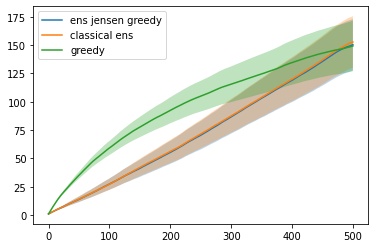

In [8]:
plt.figure()

for p_ind, policy in enumerate(policies):
    plt.plot(squeezed_utilities[p_ind].mean(axis=0), label=policy)
    lower, upper = DescrStatsW(squeezed_utilities[p_ind]).tconfint_mean()
    plt.fill_between(np.arange(init_size + budget), lower, upper, alpha=0.3)
    
    print(lower[-1], upper[-1])
    print((upper[-1] - lower[-1]) / 4)
    
plt.legend();